In [16]:
# データ加工・処理・分析ライブラリ
import numpy as np
import numpy.random as random
import scipy as sp
from pandas import Series, DataFrame
import pandas as pd

# 可視化ライブラリ
import matplotlib.pyplot as plt
import japanize_matplotlib
import matplotlib as mpl
from matplotlib.lines import Line2D
import seaborn as sns
%matplotlib inline

# 機械学習ライブラリ
import sklearn
# インポート
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.signal import butter, filtfilt
from scipy.signal import find_peaks

from biosppy.signals import ecg
from scipy.signal import welch
# フォルダ内csvを読み込む
import os
import json
# 小数第3位まで表示
%precision 3

'%.3f'

In [80]:

#定数
FOLDER_ADDRESS = r"C:\Users\ginnt\OneDrive - 西日本工業大学\s220101_anabuki\研究データ\安静・作業比較実験\作業後\一回目\ploter.ipynb"

#変数の間
#csvファイルの番号
csv_columns_number = 0
#カラムの番号
columns_number = 2

#関数の間
#同一フォルダ内のcsvファイルの名前を取得
def get_csv_files_in_same_folder(path):

    # 現在のノートブックのディレクトリを取得 
    notebook_directory = os.path.dirname(os.path.abspath(path))
    # フォルダ内のファイル一覧を取得
    files = os.listdir(notebook_directory)

    # CSVファイルのみを抽出
    csv_files = [file for file in files if file.endswith(".csv")]

    return csv_files

def read_csv(csv_files_list):

    # ファイル名を保存する配列を作成（最低限の大きさで初期化）
    file_names_array = [None] * len(csv_files_list)

    # 配列にファイル名を格納
    for i, csv_file in enumerate(csv_files_list):
        file_names_array[i] = csv_file
        print(file_names_array[i])
    
    #csvの読込み
    read_df = [0]*len(file_names_array)
    for i in range(len(file_names_array)):
        read_df[i] = pd.read_csv(file_names_array[i])

    return read_df

def read_json_file(file_name, header=None):
    try:
        if not file_name.endswith('.json'):
            file_name += '.json'
            
        with open(file_name, 'r') as file:
            data = json.load(file)
            
            if header:
                if header in data:
                    return data[header]
                else:
                    print(f"Error: Header '{header}' not found in the JSON file.")
            else:
                return data
    except FileNotFoundError:
        print(f"Error: File '{file_name}' not found.")
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON: {e}")
    except Exception as e:
        print(f"Error: {e}")

def convert_time_to_seconds(time_list):
    try:
        result_list = []

        for time_str in time_list:
            minutes, seconds = map(float, time_str.split(':'))
            total_seconds = minutes * 60 + seconds
            result_list.append(int(total_seconds))

        return result_list
    except ValueError:
        print("Error: Invalid time format. Use 'mm:ss.SS' format.")
    except Exception as e:
        print(f"Error: {e}")

#グラフの名前を日本語にする.
def label_trans(name_data):

    label_name = {
        'acc_x(G)':'加速度[x軸]',
        'acc_y(G)':'加速度[y軸]',
        'acc_z(G)':'加速度[z軸]',
        'ecg(mV)':'心電図[mV]',
        'activity(G)':'活動量[G]',
        'heart_rate(bpm)':'心拍数[bpm]',
        'cadence(spm)':'ケイデンス[spm]',
        'minute_ventilation(ml/min)':'換気量[ml/分]',
        'tidal_volume(ml)':'一回換気量[ml]',
        'minute_ventilation_adjusted(ml/min)':'換気量[ml/min]',
        'tidal_volume_adjusted(ml)':'一回換気量[ml]',
        'breathing_rate(rpm)':'呼吸数[rpm]',
        'resp_thoracic(-)':'呼吸センサ（胸部）',
        'resp_abdominal(-)':'呼吸センサ（腹部）',
    }

    if type(name_data) == type('str'):
        label_return = label_name[name_data]
    else:
        print("str（文字）を入力してください.")
        label_return = " "
    
    return label_return
    
def fig_name_trans(label_data):
    save_name = {
        'acc_x(G)':'加速度[x軸]',
        'acc_y(G)':'加速度[y軸]',
        'acc_z(G)':'加速度[z軸]',
        'ecg(mV)':'心電図[mV]',
        'activity(G)':'活動量[G]',
        'heart_rate(bpm)':'心拍数[bpm]',
        'cadence(spm)':'ケイデンス[spm]',
        'minute_ventilation(ml/min)':'換気量',
        'tidal_volume(ml)':'一回換気量[ml]',
        'minute_ventilation_adjusted(ml/min)':'換気量',
        'tidal_volume_adjusted(ml)':'一回換気量[ml]',
        'breathing_rate(rpm)':'呼吸数[rpm]',
        'resp_thoracic(-)':'呼吸センサ(胸部)',
        'resp_thoracic(-)':'呼吸センサ(胸部)',
        'resp_abdominal(-)':'呼吸センサ(腹部)',
    }
    if type(label_data) == type('str'):
        label_return = save_name[label_data]
    else:
        print("str（文字）を入力してください.")
        label_return = " "

    return label_return

def operation_partitioning_one_ploter_ploter(df, title='Default',alpha=0.2, save_flg=False, segment=[],n=5):

        df = df[df[df.columns[0]] > 5]

        # 変数
        color = "#0000FF"
        title = title
        print(title)
        #分割時の色
        facecolor = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

        xlabel = df.columns[0]
        ylabel = df.columns
        font_size = 18
        font_family = 'MS Gothic'
        figsize = (18, 4)
        line_width = 2
        rotation = 0

        plt.rcParams["font.size"] = font_size
        plt.rcParams["font.family"] = font_family
        plt.rcParams["figure.figsize"] = figsize

        # x軸は固定
        x_axis = df[df.columns[0]]
        # 変化するのはY軸
        y_axis = ylabel

        # 名前を日本語にする
        title_label = label_trans(title)
        
        plt.title(title_label)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)

        # 適切な範囲を指定
        plt.xlim()
        plt.ylim()

        plt.xticks(rotation=rotation)

        plt.plot(x_axis, y_axis, color=color, label=ylabel, linewidth=line_width)
        """
        legend_elements = [Line2D([0], [0], color=facecolor[0], lw=line_width, label='締め',alpha=alpha+0.2),
                Line2D([0], [0], color=facecolor[1], lw=line_width, label='外し',alpha=alpha+0.2)]
        
        #凡例の表示
        plt.legend(handles=legend_elements)
        """
        plt.legend()

        #plt.legend(handles=legend_elements)
        plt.grid()

        #i = 0
        # 指定範囲に色を付ける
        for i in range(len(segment)):

            plt.axvspan(segment[i], segment[i+1], facecolor=facecolor[i % n], alpha=alpha, edgecolor='none', label='Colored Range')

        # プロットした画像を保存する
        if save_flg:

            plt.savefig(str(fig_name_trans(title)) + ".jpg")
            
        plt.show()
    
#　csv_recod_data_ploter(データフレーム,レコード番地,グラフタイトル,画像の保存)
def one_ploter(df,time,title='Default',x_range=[],save_flg=False):

    #変数
    color="#0000FF"
    facecolor = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    alpha=0.2
    title = title

    xlabel = 'Default'
    ylabel = 'Default'
    font_size = 14
    font_family = 'MS Gothic'
    figsize = (18,4)
    line_width = 1
    rotation = 0
    
    plt.rcParams["font.size"] = font_size
    plt.rcParams["font.family"] = font_family
    plt.rcParams["figure.figsize"] = figsize
    #x軸は固定
    x_axis = time
    #変化するのはY軸
    y_axis = df

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.xlim()
    plt.ylim()

    plt.xticks(rotation=rotation)

    plt.plot(x_axis,y_axis,color=color,label=ylabel,linewidth=line_width)

    legend_elements = [Line2D([0], [0], color=facecolor[0], lw=line_width, label='ねじ締_上向き'),
                Line2D([0], [0], color=facecolor[1], lw=line_width, label='ねじ締_前のめり'),
                Line2D([0], [0], color=facecolor[2], lw=2, label="ねじ外し_前のめり"),
                Line2D([0], [0], color=facecolor[3], lw=2, label="ねじ外し_上向き"), 
                Line2D([0], [0], color=facecolor[4], lw=2, label="休憩") ]

    #凡例の表示
    plt.legend(handles=legend_elements,)

    for i in range(len(x_range) - 1):

        plt.axvspan(x_range[i], x_range[i+1], facecolor=facecolor[i % 5], alpha=alpha, edgecolor='none', label='Colored Range')

    
    plt.grid()
    #プロットした画像を保存する
    if save_flg == True:
        plt.savefig(str(df.columns) + ".jpg")
    plt.show()

def all_ploter(csv_df,x_range_start=[],x_range_end=[]):
    df = csv_df[0]

    csv_file_number = 0
    csv_columns_number = 2

    #csvファイルの個数
    csv_file_number_scale = len(csv_df)
    #データフレームのカラム数
    csv_columns_number_scale = len(df.columns)

    i = 0
    while csv_file_number < csv_file_number_scale:
        #csvファイルを読み込む
        df = csv_df[csv_file_number]
        #ファイル内のデータフレームのカラム数を取得
        csv_columns_number_scale = len(df.columns)

        #カラム数よりループ回数が少ない場合:True 
        while csv_columns_number < csv_columns_number_scale:

            #指定期間でデータを強調する
            operation_partitioning_one_ploter_ploter(df, title='Default',alpha=0.2, save_flg=False, segment=[],n=5)

            plt.subplots_adjust(left=0.05, right=0.995, bottom=0.15, top=0.9)
            
            csv_columns_number += 1
            i += 1

        csv_columns_number = 2
        csv_file_number +=1
    print("END")


def calculate_statistics(dataframe,n=2):

    """
    データフレームの各カラムごとの基本統計量を計算する関数

    Parameters:
    - dataframe: pandasのDataFrame

    Returns:
    - 統計量のデータフレーム
    """
    # 基本統計量の計算
    statistics_df = round(dataframe.describe(),n)

    # 必要に応じて追加の統計量を計算する場合は以下にコードを追加

    return statistics_df
#　FFTを行う.引数は時系列データとサンプリング数
def FFTer(data,Fs=1000):
    # FFTを行う
    n = len(data)
    k = np.arange(n)
    T = n/Fs
    frq = k/T  # 2辺分の周波数レンジ
    frq = frq[range(n//2)]  # プロットする範囲を制限

    Y = np.fft.fft(data)/n  # FFTを実行して正規化
    Y = Y[range(n//2)]

    # FFTの結果をプロット
    plt.figure(figsize=(18, 4))
    plt.subplot(2, 1, 2)
    plt.plot(frq, abs(Y))
    plt.title('FFT Result')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    #plt.xlim(0,1)
    plt.grid()
    plt.tight_layout()
    plt.show()

def fft_and_filter(time_series, target_frequency_range):
    """
    時系列データに対してFFHを行い、指定した周波数帯のみを抽出して逆FFTを行う関数。

    Parameters:
    - time_series (numpy.ndarray): 入力の時系列データ
    - target_frequency_range (tuple): 抽出する周波数帯を指定するタプル (low, high)

    Returns:
    - numpy.ndarray: 指定した周波数帯のみを抽出して逆FFTを行った結果
    """

    # FFTを実行
    fft_result = np.fft.fft(time_series)

    # 周波数軸を作成
    freq_axis = np.fft.fftfreq(len(time_series))

    # 指定した周波数帯のインデックスを取得
    target_freq_indices = np.where((freq_axis >= target_frequency_range[0]) & (freq_axis <= target_frequency_range[1]))

    # 指定した周波数帯以外の要素を0にする
    fft_result_filtered = np.zeros_like(fft_result)
    fft_result_filtered[target_freq_indices] = fft_result[target_freq_indices]

    # 逆FFTを実行
    filtered_time_series = np.fft.ifft(fft_result_filtered)

    return filtered_time_series

def RR(ecg_data,time):
    # R波の検出
    peaks, _ = find_peaks(ecg_data, height=0.5) # 参考:(https://qiita.com/yamadasuzaku/items/73fcadeddb3417778b7c)

    # R-R間隔の計算
    rr_intervals = np.diff(time[peaks]) # 参考:(https://deepage.net/features/numpy-diff.html)

    # プロット
    plt.figure(figsize=(18, 4))
    plt.plot(time, ecg_data, label='ECG Data')
    plt.plot(time[peaks], ecg_data[peaks], 'x', label='R Peaks')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid()
    plt.legend()
    plt.grid()
    plt.show()

    # R-R間隔の表示
    print("R-R Intervals:", rr_intervals)
    
    return rr_intervals

def RRI_2_LFHF(dataset):

    ibi = dataset
    ibi = ibi * 1000# ミリ秒を秒に変換

    # Welch法によるPSD推定
    Fxx, Pxx = welch(ibi, fs=4.0, window='hann', nperseg=256, noverlap=128)
    print("Fxx:",Fxx)
    print("Pxx:",Pxx)

    # パラメータを設定
    vlf = 0.04
    lf = 0.15
    hf = 0.4
    Fs = 256

    # LFとHFの周波数の範囲に対応するインデックスを設定
    lf_freq_band = (Fxx >= vlf) & (Fxx <= lf)
    hf_freq_band = (Fxx >= lf) & (Fxx <= hf)

    # LFとHFの曲線の下の面積を計算
    dy = 1.0 / Fs
    LF = np.trapz(y=abs(Pxx[lf_freq_band]), x=None, dx=dy)
    HF = np.trapz(y=abs(Pxx[hf_freq_band]), x=None, dx=dy)
    LF_HF = float(LF) / HF
    print("LF:",LF)
    print("HF:",HF)
    print("LF/HF:",LF_HF)
    
    return LF_HF

def RRI_test(data,time):
    # パラメータを設定
    vlf = 0.04
    lf = 0.15
    hf = 0.4
    Fs = 256*2

    Fxx = time #時間は入力として不適切
    Pxx = data

    # LFとHFの周波数の範囲に対応するインデックスを設定
    lf_freq_band = (Fxx >= vlf) & (Fxx <= lf)
    hf_freq_band = (Fxx >= lf) & (Fxx <= hf)

    # LFとHFの曲線の下の面積を計算
    dy = 1.0 / Fs
    LF = np.trapz(y=abs(Pxx[lf_freq_band]), x=None, dx=dy)
    HF = np.trapz(y=abs(Pxx[hf_freq_band]), x=None, dx=dy)
    LF_HF = float(LF) / HF
    
    print("LF:",LF)
    print("HF:",HF)
    print("LF/HF:",LF_HF)
    
    return LF_HF
    

record-280952_ACC.csv
record-280952_ECG.csv
record-280952_Processed.csv
record-280952_RESP.csv
[119, 220, 248, 287, 348, 558, 641, 674, 712, 773, 977, 1073, 1101, 1135, 1195, 1370, 1466, 1500, 1528, 1588, 1713, 1796, 1836, 1872]


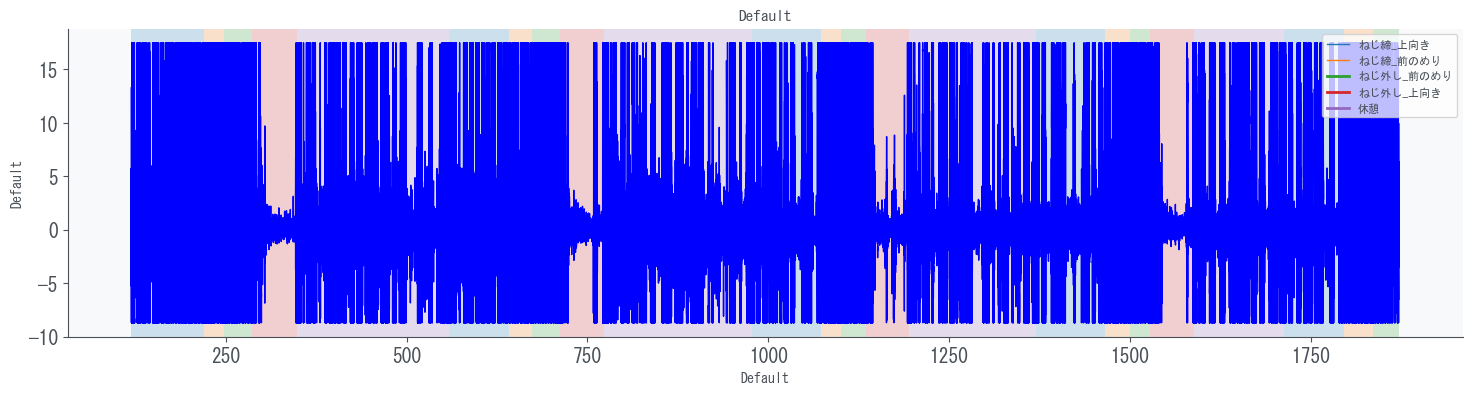

In [81]:
# jsonの読み込み
json_file_name = '安静後作業_海下_一回目_タイムスタンプ.json'
json_header = 'timestamps'  # 任意のヘッダー名

# 例えば、カレントディレクトリに 'example.json' ファイルが存在する場合
result = read_json_file(json_file_name, json_header)

result_seconds = convert_time_to_seconds(result)

# csvの読み込み
csv_files_list = get_csv_files_in_same_folder(FOLDER_ADDRESS)
df = read_csv(csv_files_list)
df = df[1]


#　作業開始と終了時の範囲を抽出
df = df[(result_seconds[0] <= df[df.columns[0]]) & (df[df.columns[0]] <= result_seconds[-1])]


ECG = df[df.columns[2]]
TIME = df[df.columns[0]]

df.reset_index(drop=True, inplace=True)

print(result_seconds)
one_ploter(df=ECG,time=TIME,title='Default',x_range=result_seconds,save_flg=False)

In [82]:

# Christovのアルゴリズムを使用してR波を検出
out = ecg.christov_segmenter(signal=ECG, sampling_rate=256)

# R波のインデックスを取得
r_peaks = out['rpeaks']
RRI_2_LFHF(r_peaks)
RR(ECG,TIME)


Fxx: [0.    0.016 0.031 0.047 0.062 0.078 0.094 0.109 0.125 0.141 0.156 0.172
 0.188 0.203 0.219 0.234 0.25  0.266 0.281 0.297 0.312 0.328 0.344 0.359
 0.375 0.391 0.406 0.422 0.438 0.453 0.469 0.484 0.5   0.516 0.531 0.547
 0.562 0.578 0.594 0.609 0.625 0.641 0.656 0.672 0.688 0.703 0.719 0.734
 0.75  0.766 0.781 0.797 0.812 0.828 0.844 0.859 0.875 0.891 0.906 0.922
 0.938 0.953 0.969 0.984 1.    1.016 1.031 1.047 1.062 1.078 1.094 1.109
 1.125 1.141 1.156 1.172 1.188 1.203 1.219 1.234 1.25  1.266 1.281 1.297
 1.312 1.328 1.344 1.359 1.375 1.391 1.406 1.422 1.438 1.453 1.469 1.484
 1.5   1.516 1.531 1.547 1.562 1.578 1.594 1.609 1.625 1.641 1.656 1.672
 1.688 1.703 1.719 1.734 1.75  1.766 1.781 1.797 1.812 1.828 1.844 1.859
 1.875 1.891 1.906 1.922 1.938 1.953 1.969 1.984 2.   ]
Pxx: [4.933e+11 4.579e+14 2.358e+13 1.463e+12 2.770e+11 1.477e+11 5.643e+10
 2.755e+10 2.474e+10 1.754e+10 1.475e+10 8.950e+09 6.728e+09 5.819e+09
 5.904e+09 4.340e+09 3.796e+09 4.147e+09 4.182e+09 5.166e+09 5

KeyError: '[42, 63, 67, 75, 81, 83, 85, 87, 112, 131, 182, 200, 204, 241, 281, 302, 315, 344, 355, 358, 374, 377, 396, 404, 407, 419, 436, 464, 469, 507, 524, 550, 563, 578, 590, 611, 645, 668, 693, 697, 699, 701, 704, 713, 722, 744, 749, 756, 767, 788, 791, 831, 859, 871, 874, 890, 903, 940, 952, 956, 971, 991, 994, 1008, 1013, 1016, 1044, 1096, 1104, 1122, 1128, 1136, 1147, 1182, 1184, 1190, 1200, 1211, 1311, 1401, 1439, 1491, 1494, 1534, 1548, 1553, 1559, 1575, 1578, 1583, 1587, 1592, 1598, 1604, 1610, 1613, 1623, 1629, 1631, 1635, 1640, 1644, 1648, 1667, 1673, 1688, 1797, 1834, 1867, 1878, 1884, 1905, 1914, 1921, 1957, 1986, 1990, 2001, 2005, 2014, 2018, 2043, 2046, 2050, 2055, 2059, 2091, 2096, 2101, 2106, 2115, 2139, 2144, 2150, 2156, 2160, 2164, 2168, 2175, 2180, 2184, 2189, 2205, 2215, 2218, 2226, 2228, 2233, 2238, 2266, 2285, 2293, 2299, 2304, 2313, 2318, 2324, 2326, 2334, 2354, 2362, 2366, 2370, 2378, 2384, 2392, 2419, 2429, 2447, 2462, 2468, 2475, 2482, 2500, 2506, 2513, 2517, 2520, 2585, 2606, 2629, 2646, 2658, 2682, 2702, 2708, 2713, 2719, 2723, 2729, 2733, 2752, 2761, 2763, 2772, 2774, 2777, 2792, 2816, 2823, 2827, 2842, 2847, 2859, 2868, 2889, 2918, 2929, 2974, 2995, 3014, 3030, 3035, 3043, 3050, 3055, 3059, 3067, 3082, 3107, 3112, 3118, 3129, 3134, 3150, 3183, 3186, 3204, 3208, 3210, 3218, 3220, 3225, 3252, 3265, 3269, 3273, 3287, 3333, 3342, 3348, 3361, 3372, 3374, 3379, 3388, 3393, 3402, 3405, 3408, 3459, 3483, 3496, 3504, 3525, 3555, 3559, 3565, 3573, 3578, 3584, 3593, 3604, 3615, 3619, 3632, 3649, 3661, 3703, 3708, 3721, 3737, 3757, 3774, 3787, 3794, 3810, 3922, 3972, 3983, 3996, 4005, 4009, 4012, 4041, 4048, 4052, 4054, 4058, 4079, 4086, 4094, 4100, 4116, 4124, 4128, 4147, 4155, 4159, 4166, 4181, 4190, 4197, 4207, 4214, 4217, 4220, 4226, 4232, 4247, 4250, 4254, 4257, 4259, 4268, 4272, 4279, 4288, 4293, 4298, 4303, 4306, 4309, 4323, 4327, 4334, 4344, 4359, 4437, 4470, 4579, 4583, 4600, 4617, 4621, 4635, 4652, 4655, 4676, 4681, 4690, 4700, 4707, 4715, 4725, 4739, 4749, 4756, 4773, 4783, 4798, 4815, 4827, 4841, 4870, 4879, 4882, 4901, 4903, 4915, 4919, 4927, 4946, 4956, 4975, 4981, 5000, 5006, 5011, 5025, 5027, 5044, 5062, 5083, 5103, 5119, 5165, 5178, 5200, 5207, 5212, 5215, 5288, 5297, 5354, 5356, 5362, 5373, 5379, 5386, 5399, 5437, 5442, 5448, 5459, 5465, 5495, 5511, 5514, 5526, 5542, 5552, 5567, 5573, 5602, 5607, 5609, 5613, 5620, 5624, 5629, 5661, 5678, 5681, 5689, 5691, 5700, 5715, 5717, 5721, 5727, 5763, 5821, 5825, 5837, 5840, 5845, 5856, 5865, 5907, 5919, 5924, 5933, 5936, 5976, 5988, 5994, 5998, 6024, 6033, 6051, 6063, 6099, 6108, 6122, 6126, 6132, 6146, 6150, 6153, 6155, 6164, 6173, 6184, 6192, 6208, 6227, 6290, 6315, 6328, 6333, 6335, 6345, 6427, 6431, 6449, 6455, 6459, 6467, 6475, 6478, 6483, 6490, 6517, 6539, 6561, 6568, 6571, 6575, 6582, 6586, 6592, 6601, 6614, 6618, 6626, 6631, 6636, 6643, 6674, 6696, 6698, 6713, 6715, 6717, 6720, 6739, 6747, 6753, 6757, 6763, 6765, 6773, 6785, 6793, 6809, 6817, 6822, 6829, 6843, 6848, 6854, 6859, 6864, 6870, 6875, 6924, 6945, 6982, 7000, 7003, 7023, 7030, 7035, 7044, 7067, 7071, 7088, 7094, 7098, 7116, 7120, 7142, 7145, 7168, 7246, 7262, 7265, 7271, 7275, 7341, 7350, 7359, 7365, 7369, 7377, 7386, 7391, 7410, 7433, 7451, 7455, 7473, 7486, 7500, 7510, 7512, 7522, 7533, 7549, 7551, 7576, 7581, 7594, 7608, 7616, 7626, 7635, 7649, 7653, 7702, 7723, 7733, 7741, 7744, 7748, 7751, 7753, 7758, 7771, 7774, 7804, 7806, 7812, 7833, 7835, 7855, 7864, 7868, 7872, 7877, 7880, 7889, 7912, 7914, 7918, 7920, 7922, 7926, 7932, 7992, 8019, 8066, 8094, 8109, 8127, 8147, 8172, 8186, 8194, 8225, 8239, 8247, 8283, 8306, 8320, 8328, 8355, 8367, 8369, 8371, 8376, 8383, 8403, 8445, 8457, 8465, 8477, 8501, 8529, 8533, 8540, 8549, 8563, 8609, 8619, 8632, 8637, 8656, 8699, 8702, 8704, 8718, 8736, 8841, 8855, 8864, 8967, 8969, 8973, 8978, 8992, 9003, 9025, 9043, 9046, 9073, 9079, 9085, 9088, 9093, 9100, 9153, 9161, 9170, 9174, 9177, 9188, 9201, 9209, 9217, 9240, 9246, 9257, 9271, 9341, 9371, 9390, 9419, 9423, 9434, 9437, 9447, 9456, 9466, 9477, 9479, 9482, 9485, 9507, 9515, 9530, 9537, 9552, 9579, 9584, 9589, 9591, 9593, 9598, 9611, 9626, 9641, 9647, 9650, 9657, 9691, 9778, 9783, 9855, 9863, 9870, 9892, 9903, 9907, 9978, 9985, 10003, 10007, 10049, 10054, 10057, 10063, 10071, 10092, 10098, 10104, 10108, 10114, 10126, 10130, 10137, 10149, 10153, 10156, 10161, 10166, 10175, 10180, 10198, 10203, 10207, 10213, 10219, 10224, 10248, 10251, 10256, 10265, 10269, 10276, 10283, 10286, 10289, 10308, 10320, 10332, 10334, 10348, 10377, 10390, 10393, 10396, 10405, 10407, 10415, 10420, 10431, 10445, 10466, 10482, 10493, 10509, 10542, 10557, 10576, 10583, 10624, 10643, 10653, 10659, 10664, 10678, 10753, 10758, 10768, 10821, 10850, 10890, 10896, 10918, 10944, 10955, 10964, 11010, 11016, 11027, 11037, 11041, 11048, 11076, 11096, 11100, 11116, 11128, 11130, 11134, 11139, 11220, 11261, 11272, 11277, 11287, 11309, 11340, 11347, 11353, 11364, 11396, 11399, 11415, 11421, 11426, 11430, 11455, 11462, 11468, 11472, 11487, 11490, 11503, 11515, 11527, 11532, 11538, 11547, 11559, 11566, 11568, 11572, 11581, 11590, 11594, 11615, 11622, 11624, 11629, 11634, 11638, 11642, 11646, 11657, 11665, 11711, 11721, 11724, 11731, 11735, 11740, 11756, 11799, 11810, 11816, 11826, 11898, 11903, 11909, 11916, 11919, 11922, 12032, 12040, 12068, 12072, 12075, 12081, 12083, 12089, 12117, 12120, 12125, 12146, 12153, 12155, 12170, 12172, 12180, 12192, 12289, 12311, 12331, 12387, 12394, 12405, 12414, 12439, 12473, 12509, 12547, 12556, 12565, 12569, 12573, 12613, 12630, 12639, 12648, 12664, 12679, 12684, 12690, 12705, 12747, 12750, 12753, 12762, 12785, 12790, 12794, 12817, 12821, 12905, 12934, 12939, 12945, 12978, 12985, 12988, 12991, 12997, 13006, 13012, 13018, 13025, 13037, 13047, 13051, 13056, 13082, 13086, 13106, 13123, 13150, 13228, 13236, 13273, 13277, 13281, 13302, 13308, 13313, 13319, 13322, 13330, 13335, 13339, 13346, 13477, 13480, 13484, 13490, 13499, 13502, 13508, 13519, 13525, 13530, 13540, 13546, 13553, 13558, 13564, 13568, 13570, 13574, 13589, 13661, 13669, 13678, 13684, 13694, 13702, 13773, 13810, 13818, 13823, 13857, 13893, 13898, 13901, 13914, 13917, 13921, 13967, 14001, 14081, 14110, 14119, 14136, 14145, 14149, 14163, 14172, 14180, 14187, 14197, 14218, 14220, 14232, 14242, 14251, 14264, 14270, 14277, 14285, 14291, 14304, 14311, 14335, 14351, 14458, 14473, 14488, 14502, 14508, 14529, 14580, 14688, 14692, 14738, 14751, 14763, 14768, 14775, 14787, 14793, 14795, 14802, 14819, 14829, 14891, 14900, 14905, 14931, 14954, 14971, 14985, 14993, 15007, 15012, 15016, 15020, 15029, 15036, 15089, 15110, 15114, 15120, 15140, 15167, 15170, 15187, 15194, 15198, 15209, 15211, 15226, 15244, 15252, 15256, 15259, 15263, 15269, 15273, 15285, 15292, 15296, 15322, 15344, 15354, 15359, 15369, 15375, 15386, 15407, 15413, 15428, 15439, 15442, 15446, 15449, 15454, 15459, 15464, 15467, 15473, 15481, 15573, 15575, 15577, 15579, 15610, 15618, 15626, 15632, 15637, 15640, 15660, 15688, 15692, 15714, 15794, 15810, 15832, 15842, 15850, 15858, 15863, 15866, 15874, 15918, 15932, 15973, 15976, 15982, 15991, 15993, 16037, 16039, 16059, 16082, 16147, 16159, 16164, 16197, 16202, 16207, 16220, 16224, 16236, 16244, 16247, 16333, 16338, 16342, 16358, 16371, 16374, 16397, 16401, 16414, 16425, 16430, 16444, 16452, 16467, 16473, 16476, 16483, 16487, 16497, 16506, 16511, 16516, 16521, 16526, 16531, 16536, 16541, 16546, 16551, 16556, 16562, 16567, 16572, 16578, 16582, 16588, 16593, 16598, 16603, 16608, 16613, 16619, 16656, 16661, 16668, 16672, 16677, 16680, 16691, 16694, 16700, 16704, 16719, 16732, 16737, 16739, 16752, 16764, 16772, 16778, 16819, 16835, 16854, 16865, 16868, 16918, 16928, 16935, 16940, 16953, 16964, 16978, 16985, 16987, 16993, 17005, 17052, 17056, 17063, 17121, 17127, 17133, 17141, 17176, 17214, 17248, 17257, 17355, 17371, 17382, 17393, 17396, 17400, 17415, 17429, 17433, 17435, 17444, 17461, 17466, 17482, 17500, 17513, 17517, 17522, 17534, 17536, 17543, 17547, 17579, 17586, 17593, 17597, 17603, 17615, 17621, 17626, 17684, 17688, 17703, 17715, 17748, 17764, 17779, 17787, 17811, 17846, 17860, 17874, 17881, 17887, 17890, 17900, 17905, 17928, 17931, 17946, 17951, 17956, 17968, 17988, 17995, 18002, 18004, 18013, 18017, 18019, 18022, 18024, 18027, 18029, 18034, 18057, 18064, 18087, 18102, 18106, 18112, 18120, 18143, 18165, 18189, 18195, 18226, 18352, 18368, 18372, 18378, 18382, 18387, 18393, 18397, 18401, 18421, 18424, 18426, 18430, 18438, 18441, 18445, 18450, 18454, 18457, 18462, 18466, 18472, 18479, 18487, 18491, 18495, 18505, 18509, 18512, 18527, 18531, 18540, 18548, 18568, 18574, 18576, 18583, 18588, 18638, 18660, 18671, 18678, 18685, 18692, 18700, 18705, 18711, 18715, 18721, 18732, 18737, 18742, 18748, 18767, 18772, 18777, 18783, 18795, 18809, 18823, 18837, 18868, 18879, 18891, 18926, 18946, 18950, 18956, 19018, 19041, 19053, 19063, 19067, 19072, 19078, 19084, 19098, 19115, 19119, 19127, 19132, 19137, 19152, 19163, 19166, 19169, 19176, 19210, 19213, 19217, 19221, 19231, 19240, 19254, 19263, 19268, 19273, 19280, 19283, 19289, 19292, 19315, 19322, 19333, 19339, 19345, 19353, 19385, 19399, 19433, 19453, 19505, 19513, 19531, 19548, 19553, 19566, 19591, 19599, 19604, 19616, 19621, 19629, 19632, 19634, 19654, 19665, 19668, 19672, 19674, 19680, 19704, 19719, 19731, 19738, 19756, 19771, 19807, 19818, 19849, 19852, 19884, 19890, 19897, 19909, 19915, 19924, 19929, 19946, 19949, 19955, 19957, 19964, 19976, 19980, 19985, 19991, 19994, 20025, 20029, 20032, 20038, 20043, 20048, 20059, 20063, 20099, 20104, 20164, 20172, 20178, 20194, 20206, 20222, 20229, 20234, 20238, 20316, 20328, 20333, 20337, 20342, 20347, 20352, 20357, 20361, 20372, 20377, 20385, 20390, 20411, 20423, 20434, 20447, 20478, 20559, 20646, 20652, 20665, 20673, 20681, 20689, 20766, 20772, 20780, 20808, 20826, 20842, 20856, 20862, 20886, 20895, 20914, 20939, 20948, 20963, 20972, 20987, 20995, 20997, 21003, 21027, 21040, 21061, 21071, 21093, 21103, 21125, 21160, 21185, 21282, 21287, 21316, 21335, 21377, 21393, 21435, 21439, 21441, 21445, 21463, 21468, 21488, 21493, 21502, 21511, 21517, 21520, 21523, 21525, 21532, 21539, 21549, 21561, 21571, 21577, 21582, 21597, 21600, 21602, 21610, 21621, 21623, 21634, 21639, 21649, 21653, 21656, 21664, 21667, 21675, 21681, 21683, 21701, 21707, 21712, 21721, 21727, 21746, 21749, 21752, 21759, 21767, 21793, 21831, 21837, 21849, 21862, 21864, 21882, 21944, 21949, 21954, 21968, 21978, 21986, 21990, 21995, 22000, 22007, 22018, 22026, 22028, 22032, 22038, 22045, 22049, 22056, 22061, 22063, 22067, 22089, 22107, 22114, 22127, 22129, 22139, 22142, 22146, 22148, 22152, 22155, 22197, 22200, 22205, 22241, 22246, 22265, 22279, 22283, 22289, 22297, 22301, 22338, 22342, 22347, 22391, 22415, 22479, 22490, 22500, 22502, 22506, 22531, 22569, 22660, 22674, 22680, 22688, 22694, 22704, 22750, 22779, 22785, 22805, 22832, 22863, 22883, 22891, 22894, 22900, 22905, 22925, 22937, 22943, 22947, 22958, 22971, 22977, 22991, 23002, 23010, 23014, 23032, 23037, 23052, 23056, 23074, 23093, 23099, 23117, 23142, 23145, 23147, 23150, 23154, 23159, 23164, 23169, 23171, 23175, 23177, 23182, 23188, 23206, 23238, 23250, 23253, 23288, 23290, 23295, 23300, 23316, 23324, 23338, 23393, 23409, 23414, 23419, 23430, 23458, 23460, 23464, 23474, 23480, 23482, 23488, 23494, 23501, 23510, 23516, 23530, 23548, 23553, 23558, 23571, 23578, 23581, 23598, 23602, 23607, 23613, 23616, 23621, 23625, 23631, 23652, 23674, 23693, 23698, 23706, 23717, 23738, 23746, 23750, 23752, 23763, 23766, 23780, 23786, 23796, 23823, 23827, 23833, 23839, 23852, 23858, 23864, 23868, 23872, 23874, 23880, 23883, 23891, 23894, 23899, 23905, 23917, 23928, 23952, 23958, 23961, 23978, 23984, 23987, 24011, 24031, 24061, 24151, 24173, 24181, 24188, 24192, 24247, 24264, 24278, 24307, 24339, 24349, 24358, 24360, 24398, 24413, 24426, 24435, 24438, 24441, 24449, 24463, 24480, 24488, 24515, 24541, 24551, 24581, 24585, 24603, 24611, 24618, 24622, 24632, 24634, 24647, 24684, 24693, 24700, 24703, 24731, 24734, 24740, 24793, 24803, 24856, 24898, 24920, 24939, 24945, 24948, 24958, 24965, 24975, 24998, 25009, 25036, 25047, 25066, 25114, 25136, 25142, 25218, 25243, 25273, 25290, 25301, 25333, 25345, 25362, 25413, 25450, 25455, 25481, 25491, 25505, 25511, 25541, 25588, 25597, 25604, 25618, 25622, 25629, 25674, 25678, 25680, 25702, 25732, 25752, 25766, 25773, 25787, 25793, 25798, 25805, 25807, 25809, 25814, 25820, 25823, 25851, 25871, 25873, 25883, 25903, 25919, 25932, 25935, 25942, 25949, 25976, 25992, 25999, 26007, 26009, 26013, 26017, 26026, 26034, 26059, 26086, 26114, 26167, 26184, 26200, 26219, 26230, 26239, 26253, 26274, 26287, 26291, 26295, 26303, 26336, 26367, 26379, 26384, 26389, 26394, 26399, 26407, 26411, 26468, 26471, 26480, 26487, 26498, 26528, 26547, 26554, 26561, 26578, 26608, 26611, 26629, 26645, 26651, 26670, 26698, 26719, 26726, 26728, 26731, 26773, 26777, 26786, 26790, 26801, 26818, 26823, 26829, 26836, 26845, 26851, 26917, 26931, 26940, 26954, 26996, 27002, 27009, 27024, 27058, 27062, 27064, 27069, 27077, 27080, 27088, 27092, 27096, 27099, 27103, 27135, 27144, 27155, 27176, 27199, 27204, 27210, 27224, 27228, 27234, 27240, 27248, 27274, 27287, 27291, 27298, 27304, 27306, 27317, 27346, 27351, 27358, 27379, 27392, 27406, 27414, 27448, 27451, 27473, 27477, 27480, 27498, 27500, 27506, 27509, 27513, 27516, 27519, 27521, 27524, 27528, 27532, 27560, 27562, 27564, 27570, 27573, 27577, 27583, 27587, 27593, 27596, 27599, 27601, 27619, 27624, 27630, 27643, 27654, 27664, 27667, 27680, 27754, 27870, 27875, 27883, 27885, 27905, 27911, 27915, 27917, 27931, 27938, 27943, 27945, 27973, 27981, 28001, 28012, 28021, 28064, 28085, 28092, 28104, 28118, 28173, 28175, 28205, 28219, 28223, 28226, 28231, 28252, 28285, 28296, 28301, 28311, 28315, 28317, 28324, 28332, 28345, 28354, 28361, 28369, 28375, 28380, 28386, 28392, 28498, 28525, 28534, 28539, 28542, 28546, 28552, 28558, 28568, 28592, 28631, 28638, 28643, 28653, 28660, 28666, 28673, 28682, 28685, 28690, 28699, 28708, 28734, 28742, 28751, 28759, 28772, 28778, 28788, 28801, 28804, 28807, 28810, 28831, 28836, 28844, 28861, 28871, 28887, 28922, 28938, 28949, 28954, 28988, 28996, 29020, 29038, 29041, 29044, 29047, 29051, 29054, 29057, 29060, 29076, 29080, 29092, 29094, 29105, 29114, 29117, 29122, 29125, 29130, 29133, 29135, 29138, 29140, 29154, 29167, 29173, 29177, 29320, 29329, 29335, 29345, 29350, 29364, 29367, 29373, 29377, 29381, 29386, 29393, 29399, 29402, 29416, 29420, 29455, 29465, 29470, 29477, 29481, 29489, 29496, 29500, 29517, 29526, 29536, 29542, 29546, 29566, 29610, 29615, 29640, 29648, 29673, 29696, 29746, 29767, 29803, 29820, 29841, 29849, 29866, 29875, 29879, 29888, 29890, 29899, 29907, 29913, 29932, 29935, 29939, 29943, 29963, 29967, 30002, 30010, 30018, 30036, 30054, 30069, 30074, 30076, 30080, 30091, 30097, 30119, 30196, 30200, 30205, 30212, 30219, 30226, 30232, 30239, 30247, 30258, 30268, 30276, 30283, 30291, 30293, 30300, 30304, 30309, 30317, 30324, 30332, 30340, 30344, 30353, 30358, 30361, 30369, 30371, 30375, 30377, 30385, 30391, 30399, 30404, 30410, 30420, 30463] not in index'